# Business Case: OLA - Churn Prediction

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

In [193]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,precision_recall_curve,accuracy_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [21]:
df = pd.read_csv("ola_driver_scaler.csv")
df.drop(columns=['Unnamed: 0'],inplace=True)

In [22]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [40]:
df.shape

(19104, 13)

In [45]:
df.dtypes

MMM-YY                  datetime64[ns]
Driver_ID                        int64
Age                            float64
Gender                         float64
City                            object
Education_Level                  int64
Income                           int64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Joining Designation              int64
Grade                            int64
Total Business Value             int64
Quarterly Rating                 int64
dtype: object

In [44]:
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])   # converting all the date columns to date types

In [25]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,2019-02-01,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2019-03-01,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,2020-11-01,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,2020-12-01,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [26]:
df.isna().sum()    # age and gender have nulls we need to fill, Lastworkingdate nulls can be ignored as they are part of target

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

#### After checking age and gender missing values we can back fill or forward fill based on the same driver ids , so using KNN imputation with 1 neighbour to fill with same driver_id with age and gender

In [27]:
gender_na = df.loc[df['Gender'].isna(),'Driver_ID'].values
age_na = df.loc[df['Age'].isna(),'Driver_ID'].values

In [28]:
df_na =  df.loc[df['Driver_ID'].isin(gender_na),['Driver_ID','Age','Gender']]

In [29]:
df_na.head()

,Driver_ID,Age,Gender
239,43,27.0,1.0
240,43,27.0,NaN
257,49,21.0,0.0
258,49,21.0,NaN
259,49,21.0,0.0


In [30]:
df_na = df[['Driver_ID','Age','Gender']]

In [32]:
imputer = KNNImputer(n_neighbors=1)
imput = imputer.fit_transform(df_na)
df_na = pd.DataFrame(imput,columns=df_na.columns)

In [33]:
df_na.isna().sum()

Driver_ID    0
Age          0
Gender       0
dtype: int64

In [34]:
df['Gender'] = df_na['Gender']
df['Age'] = df_na['Age']

In [38]:
df['Gender'].unique(),df['Age'].unique()

(array([0., 1.]),
 array([28., 31., 43., 29., 34., 35., 30., 39., 42., 27., 26., 33., 40.,
        41., 32., 22., 44., 36., 21., 49., 37., 38., 46., 47., 48., 25.,
        24., 45., 51., 52., 23., 50., 53., 54., 55., 58.]))

In [202]:
df.isna().sum()  # we imputed this nulls of age and gender

MMM-YY                      0
Driver_ID                   0
Age                         0
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
target                      0
income_sum                  0
income_mean                 0
income_min                  0
tbv_mean                    0
tbv_min                     0
grade_growth            16723
dtype: int64

In [46]:
df.sort_values(by=['Driver_ID', 'MMM-YY'],inplace=True,ignore_index=True)

#### Getting unique driver rows and aggregating few columns based on the feature

In [47]:
df_u = df.drop_duplicates(subset=['Driver_ID'],keep="last",ignore_index=True)

In [48]:
df_u['target'] = df_u['LastWorkingDate'].notna().apply(int)

C:\Users\bharath.d.reddy\AppData\Local\Temp\ipykernel_28184\1014406890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_u['target'] = df_u['LastWorkingDate'].notna().apply(int)


In [51]:
df_u['target'].value_counts(dropna=False)

1    1616
0     765
Name: target, dtype: int64

In [56]:
df = df.merge(df_u[['Driver_ID','target']],how='left' ,on='Driver_ID')

#### While aggregating few columns we are checking how do aggregate and what features needs to be created for the models

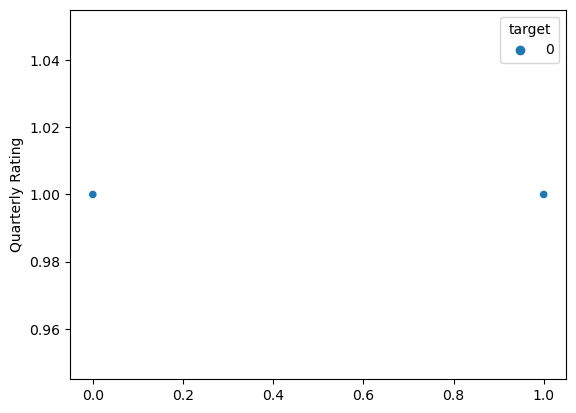

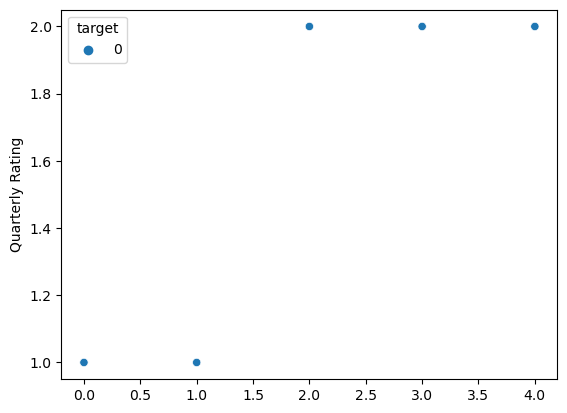

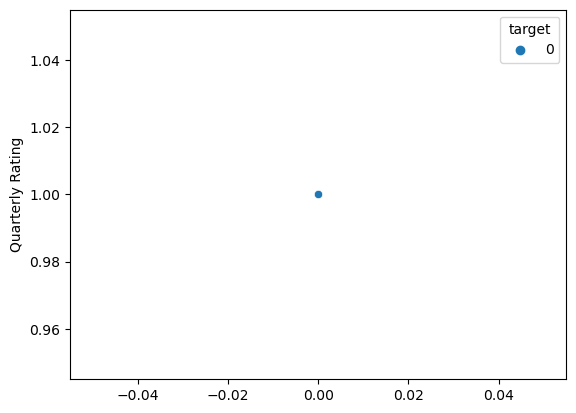

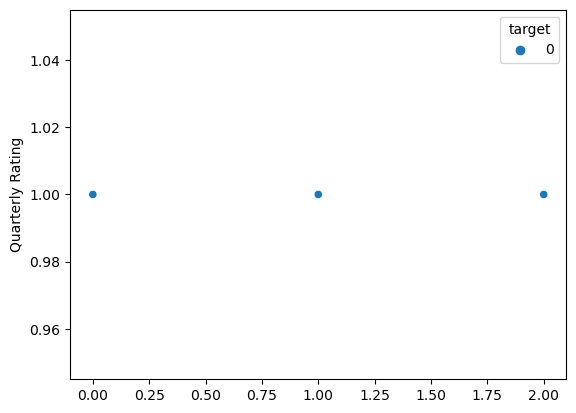

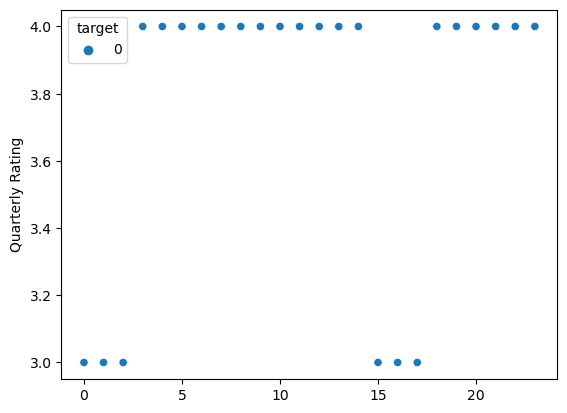

In [57]:
for i,d in enumerate(df['Driver_ID'].unique()):
    df_ = df[df['Driver_ID']==d]
    if sum(df_['target'])==0:
        sns.scatterplot(data=df_,y='Quarterly Rating',x=range(len(df_)),hue=df_['target'])
        plt.show()
        if i>10:
            break

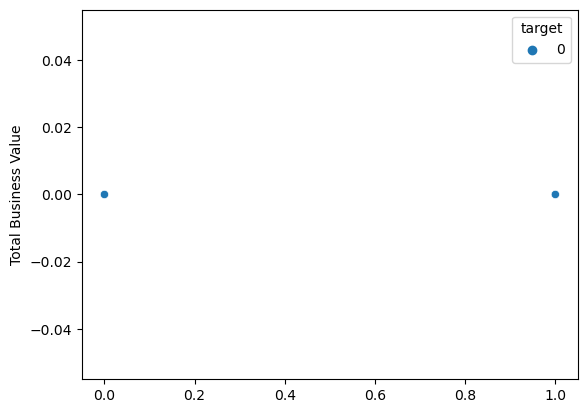

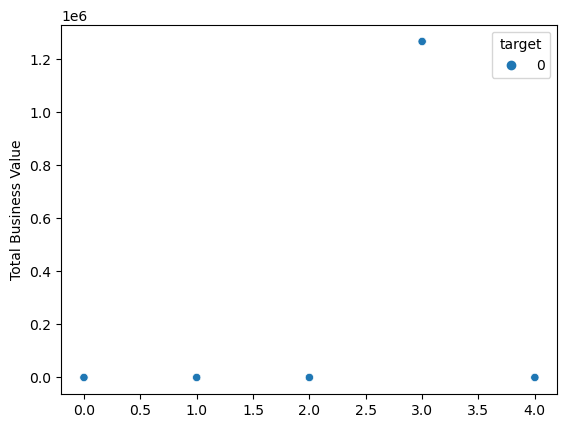

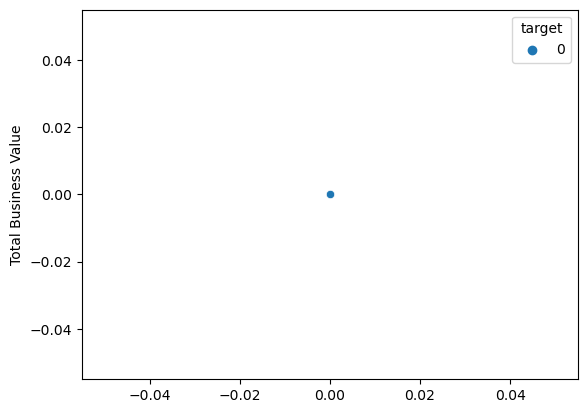

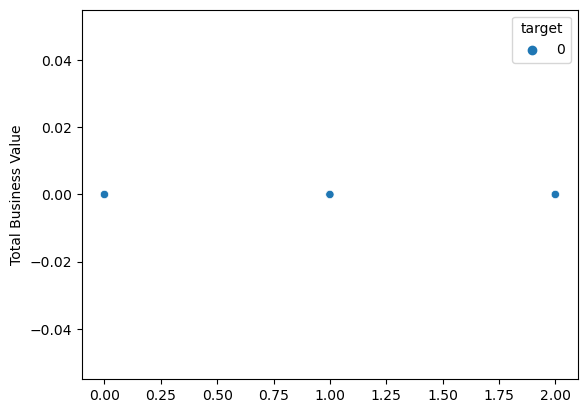

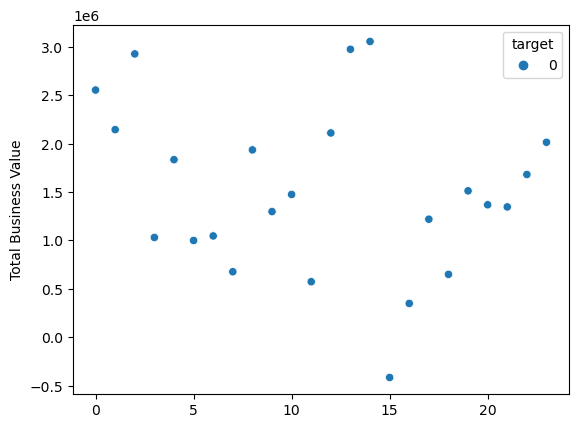

In [58]:
for i,d in enumerate(df['Driver_ID'].unique()):
    df_ = df[df['Driver_ID']==d]
    if sum(df_['target'])==0:
        sns.scatterplot(data=df_,y='Total Business Value',x=range(len(df_)),hue=df_['target'])
        plt.show()
        if i>10:
            break

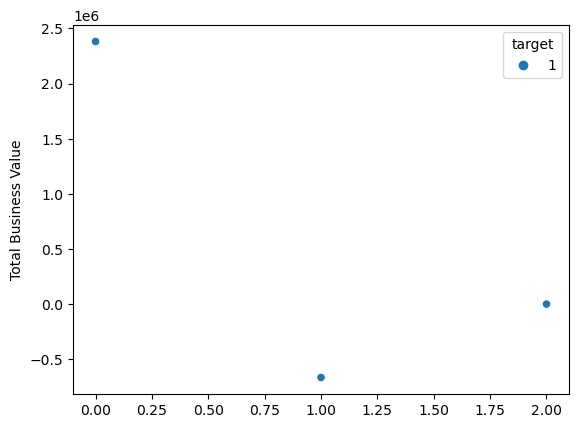

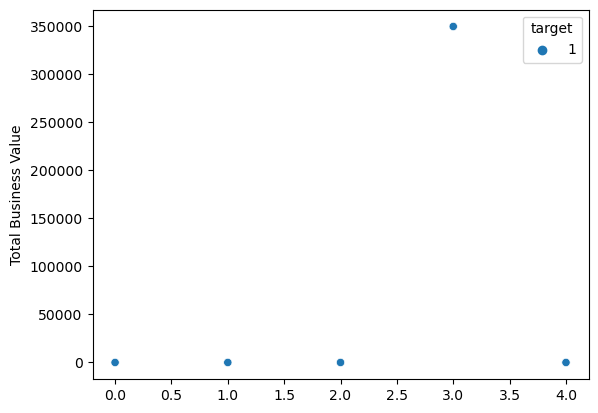

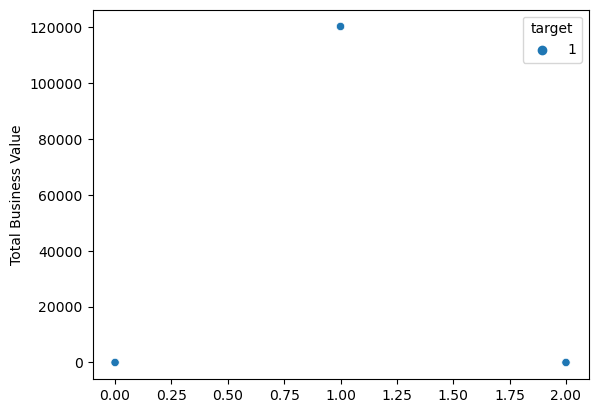

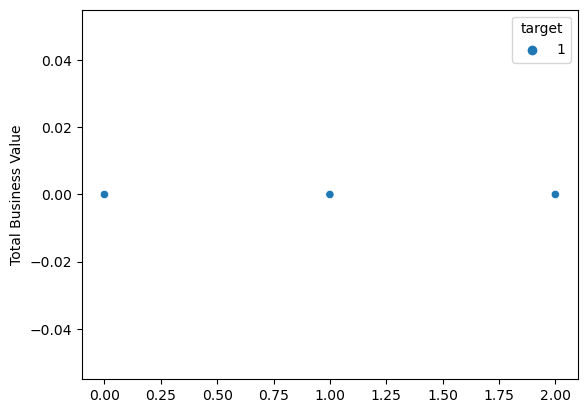

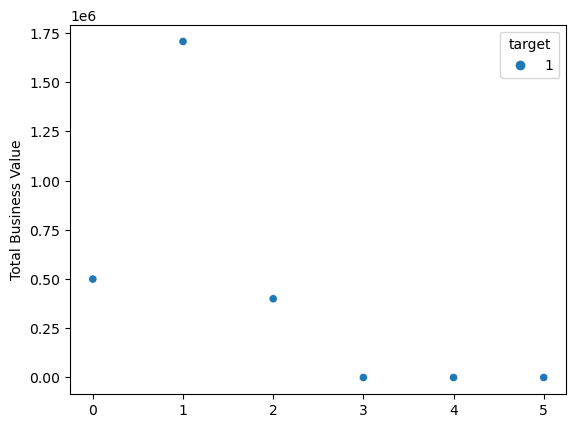

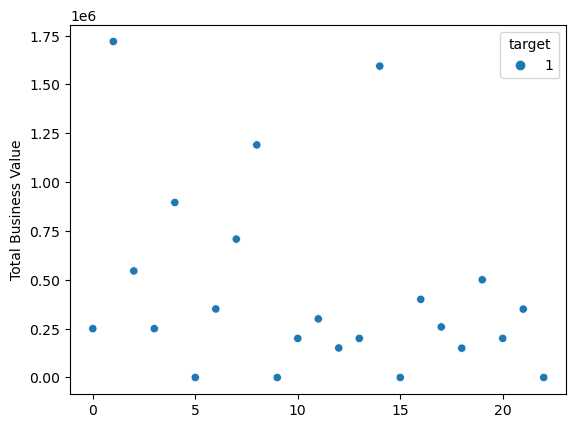

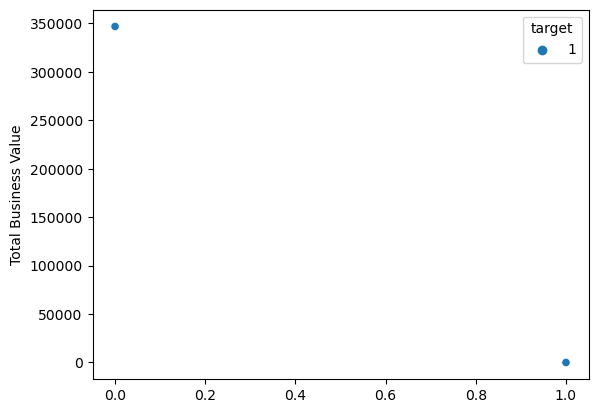

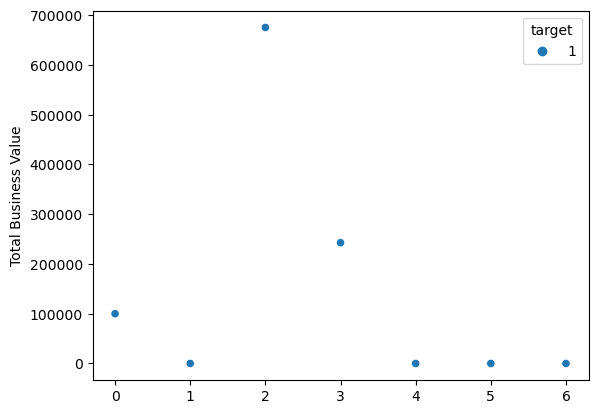

In [59]:
for i,d in enumerate(df['Driver_ID'].unique()):
    df_ = df[df['Driver_ID']==d]
    if sum(df_['target'])>0:
        sns.scatterplot(data=df_,y='Total Business Value',x=range(len(df_)),hue=df_['target'])
        plt.show()
        if i>10:
            break

In [52]:
z_val_q = []
for i,d in enumerate(df_u['Driver_ID'].tolist()):
    df_= df[df['Driver_ID']==d]
    q_rate = df_['Quarterly Rating'].values
    z = 1.0*(q_rate[-1]-q_rate.mean())/q_rate.std()
    z_val_q.append(z)

C:\Users\bharath.d.reddy\AppData\Local\Temp\ipykernel_28184\3461315518.py:5: RuntimeWarning: invalid value encountered in double_scalars
  z = 1.0*(q_rate[-1]-q_rate.mean())/q_rate.std()


In [60]:
z_val_b = []
for i,d in enumerate(df_u['Driver_ID'].tolist()):
    df_= df[df['Driver_ID']==d]
    q_rate = df_['Total Business Value'].values
    z = 1.0*(q_rate[-1]-q_rate.mean())/q_rate.std()
    z_val_b.append(z)

C:\Users\bharath.d.reddy\AppData\Local\Temp\ipykernel_28184\1344979051.py:5: RuntimeWarning: invalid value encountered in double_scalars
  z = 1.0*(q_rate[-1]-q_rate.mean())/q_rate.std()


In [61]:
nag_val_b = []
for i,d in enumerate(df_u['Driver_ID'].tolist()):
    df_= df[df['Driver_ID']==d]
    q_rate = df_['Total Business Value'].values
    nag_val_b.append((q_rate<0).sum()>0)

In [62]:
df.shape,df_u.shape,len(z_val_q),len(z_val_b),len(nag_val_b)

((19104, 14), (2381, 14), 2381, 2381, 2381)

#### So based on the chart analysis we created Z-score for last quarter so we will know while leaving do the drivers preform low, same for business value creating z score and last feature weather business have negative months for drivers

In [63]:
df_u['q_rate_z'] = z_val_q
df_u['buss_z'] = z_val_q
df_u['buss_neg'] = nag_val_b

C:\Users\bharath.d.reddy\AppData\Local\Temp\ipykernel_28184\2492878631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_u['q_rate_z'] = z_val_q
C:\Users\bharath.d.reddy\AppData\Local\Temp\ipykernel_28184\2492878631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_u['buss_z'] = z_val_q
C:\Users\bharath.d.reddy\AppData\Local\Temp\ipykernel_28184\2492878631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [64]:
df_u.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,q_rate_z,buss_z,buss_neg
0,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2,1,NaN,NaN,True
1,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,NaN,NaN,False
2,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,0,1,1,NaN,NaN,False
3,2019-03-01,5,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,0,1,1,NaN,NaN,False
4,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,0,2,0,0.816497,0.816497,False


In [66]:
df_u = df_u.fillna(0)    # filling nulls with 0 because nulls are 

In [69]:
df_u['buss_neg'] = df_u.buss_neg.apply(int)

In [70]:
df_u.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,q_rate_z,buss_z,buss_neg
0,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11 00:00:00,1,1,0,2,1,0.000000,0.000000,1
1,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,0,2,2,0,1,0,0.000000,0.000000,0
2,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27 00:00:00,2,2,0,1,1,0.000000,0.000000,0
3,2019-03-01,5,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07 00:00:00,1,1,0,1,1,0.000000,0.000000,0
4,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,0,3,3,0,2,0,0.816497,0.816497,0


In [87]:
df_u['experience'] = ((pd.to_datetime('2020-12-31')-df_u['Dateofjoining'])/np.timedelta64(1, 'M')).apply(int)

In [ ]:
Total Business Value	

#### creating few additional columns as this columns makesense for the models

In [98]:
df_agg = df.groupby(['Driver_ID']).agg(income_sum=('Income', 'sum'), 
                               income_mean=('Income', 'mean'),
                                 income_min=('Income','min'),
                             tbv_mean=('Total Business Value', 'mean'),
                                 tbv_min=('Total Business Value','min')).reset_index()

In [102]:
df_u = df_u.merge(df_agg,on='Driver_ID',how='left')

In [105]:
df['grade_growth'] = df_u['Grade']-df_u['Joining Designation']  # creating a feature if the grade decreased since joining

In [103]:
df_u.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,...,target,q_rate_z,buss_z,buss_neg,experience,income_sum,income_mean,income_min,tbv_mean,tbv_min
0,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11 00:00:00,1,...,1,0.000000,0.000000,1,24,172161,57387.0,57387,571860.0,-665480
1,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,0,2,...,0,0.000000,0.000000,0,1,134032,67016.0,67016,0.0,0
2,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27 00:00:00,2,...,1,0.000000,0.000000,0,12,328015,65603.0,65603,70000.0,0
3,2019-03-01,5,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07 00:00:00,1,...,1,0.000000,0.000000,0,23,139104,46368.0,46368,40120.0,0
4,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,0,3,...,0,0.816497,0.816497,0,5,393640,78728.0,78728,253000.0,0


In [106]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating', 'target',
       'income_sum', 'income_mean', 'income_min', 'tbv_mean', 'tbv_min',
       'grade_growth'],
      dtype='object')

In [120]:
df_ = df_u.drop(columns=['Dateofjoining','MMM-YY','LastWorkingDate','Driver_ID'])

In [110]:
df_.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Total Business Value,Quarterly Rating,target,q_rate_z,buss_z,buss_neg,experience,income_sum,income_mean,income_min,tbv_mean,tbv_min
0,28.0,0.0,C23,2,57387,1,0,2,1,0.000000,0.000000,1,24,172161,57387.0,57387,571860.0,-665480
1,31.0,0.0,C7,2,67016,2,0,1,0,0.000000,0.000000,0,1,134032,67016.0,67016,0.0,0
2,43.0,0.0,C13,2,65603,2,0,1,1,0.000000,0.000000,0,12,328015,65603.0,65603,70000.0,0
3,29.0,0.0,C9,0,46368,1,0,1,1,0.000000,0.000000,0,23,139104,46368.0,46368,40120.0,0
4,31.0,1.0,C11,1,78728,3,0,2,0,0.816497,0.816497,0,5,393640,78728.0,78728,253000.0,0


<AxesSubplot:xlabel='Age', ylabel='Count'>

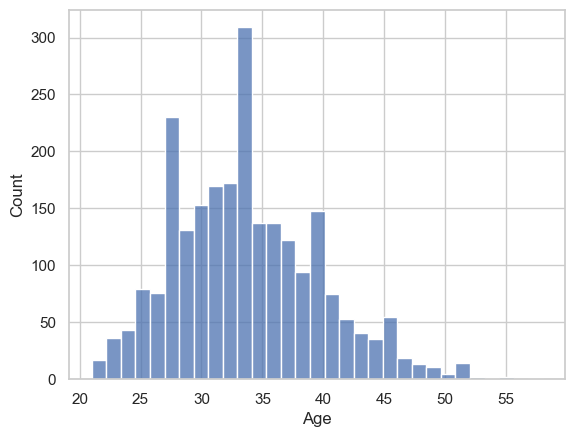

In [122]:
sns.histplot(df_['Age'])

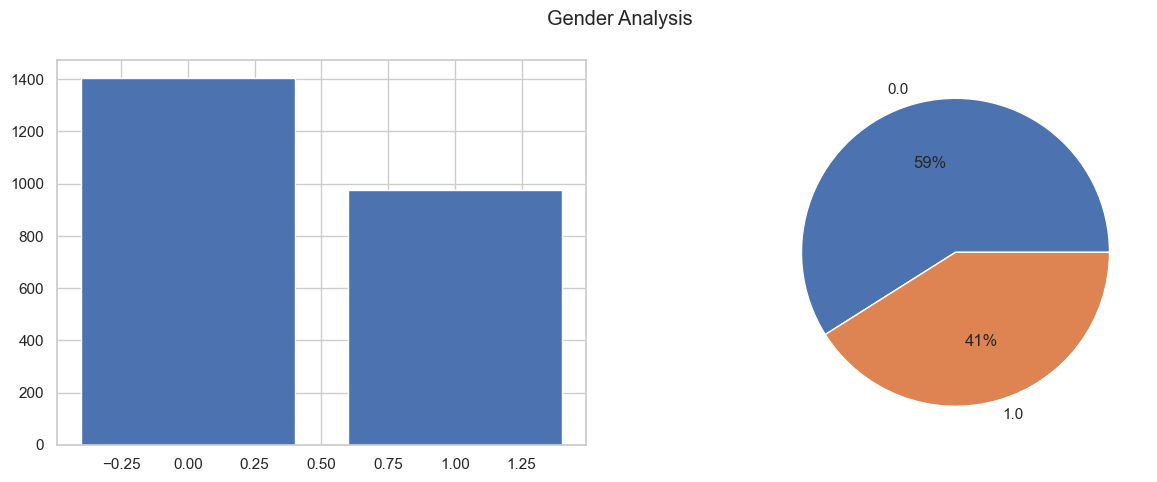

In [112]:
s_vc = df_['Gender'].value_counts()
fig, axs = plt.subplots(1, 2 , figsize =(15, 5))
fig.suptitle('Gender Analysis')
axs[0].bar(s_vc.index,s_vc.values)
axs[1].pie(s_vc.values,labels=s_vc.index, autopct='%1.0f%%')
plt.show()

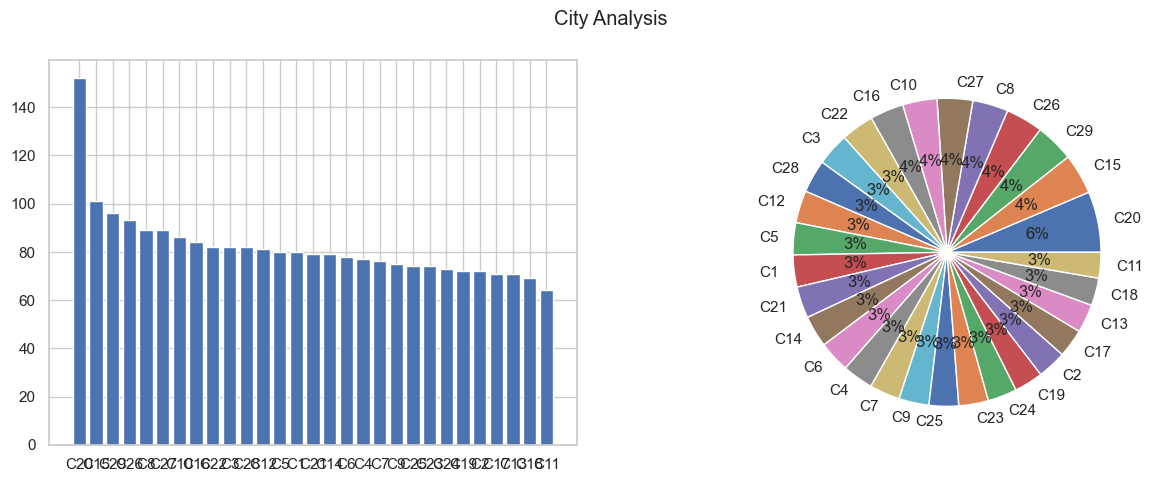

In [118]:
s_vc = df_['City'].value_counts()
fig, axs = plt.subplots(1, 2 , figsize =(15, 5))
fig.suptitle('City Analysis')
axs[0].bar(s_vc.index,s_vc.values)
axs[1].pie(s_vc.values,labels=s_vc.index, autopct='%1.0f%%')
plt.show()

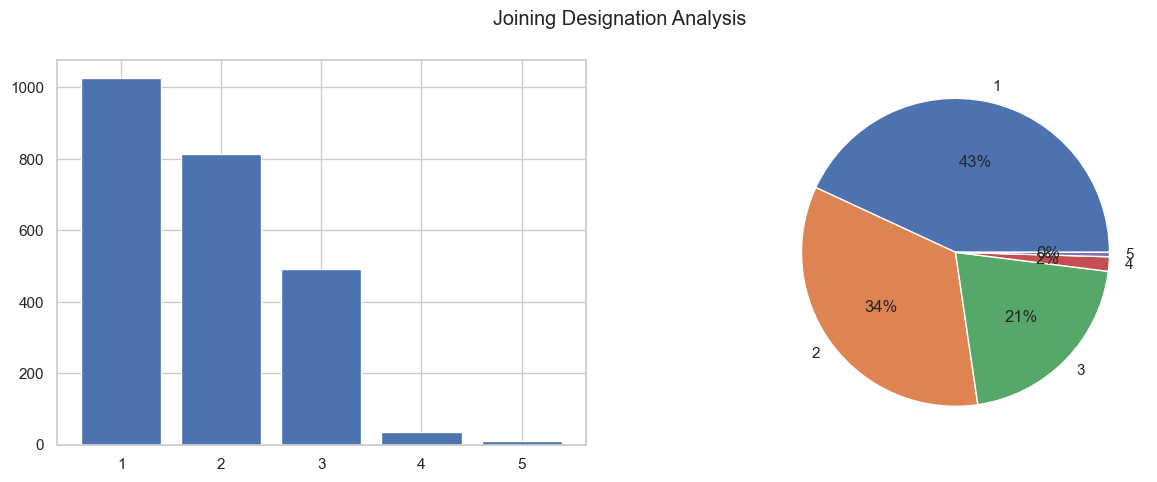

In [119]:
s_vc = df_['Joining Designation'].value_counts()
fig, axs = plt.subplots(1, 2 , figsize =(15, 5))
fig.suptitle('Joining Designation Analysis')
axs[0].bar(s_vc.index,s_vc.values)
axs[1].pie(s_vc.values,labels=s_vc.index, autopct='%1.0f%%')
plt.show()

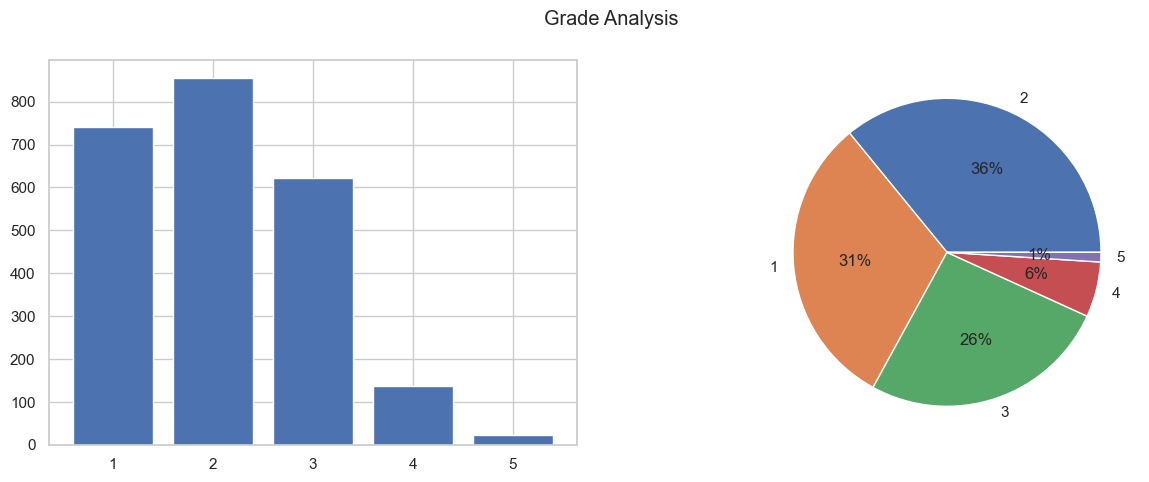

In [121]:
s_vc = df_['Grade'].value_counts()
fig, axs = plt.subplots(1, 2 , figsize =(15, 5))
fig.suptitle('Grade Analysis')
axs[0].bar(s_vc.index,s_vc.values)
axs[1].pie(s_vc.values,labels=s_vc.index, autopct='%1.0f%%')
plt.show()

<AxesSubplot:xlabel='experience', ylabel='Count'>

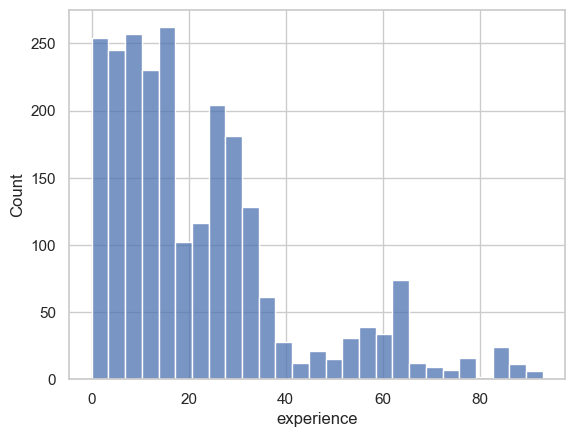

In [123]:
sns.histplot(df_['experience'])

In [125]:
df_.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,q_rate_z,buss_z,buss_neg,experience,income_sum,income_mean,income_min,tbv_mean,tbv_min
0,28.0,0.0,C23,2,57387,1,1,0,2,1,0.000000,0.000000,1,24,172161,57387.0,57387,571860.0,-665480
1,31.0,0.0,C7,2,67016,2,2,0,1,0,0.000000,0.000000,0,1,134032,67016.0,67016,0.0,0
2,43.0,0.0,C13,2,65603,2,2,0,1,1,0.000000,0.000000,0,12,328015,65603.0,65603,70000.0,0
3,29.0,0.0,C9,0,46368,1,1,0,1,1,0.000000,0.000000,0,23,139104,46368.0,46368,40120.0,0
4,31.0,1.0,C11,1,78728,3,3,0,2,0,0.816497,0.816497,0,5,393640,78728.0,78728,253000.0,0


<AxesSubplot:xlabel='Grade', ylabel='Age'>

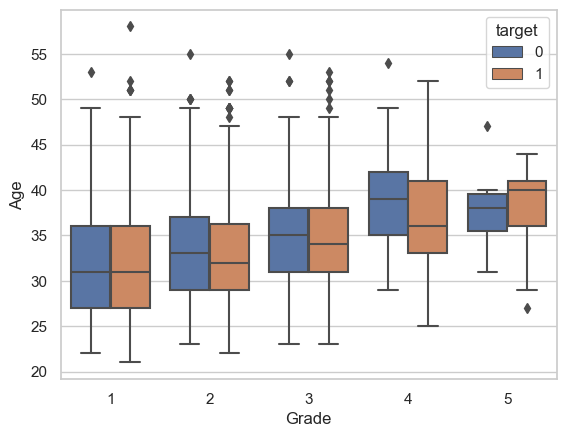

In [130]:
sns.boxplot(x=df_['Grade'],y=df_['Age'],hue=df_['target'])

In [133]:
spearman_corr = df_.corr(method='spearman')
pearson_corr = df_.corr()

In [134]:
spearman_corr = (100*spearman_corr).round(2)
pearson_corr = (100*pearson_corr).round(2)

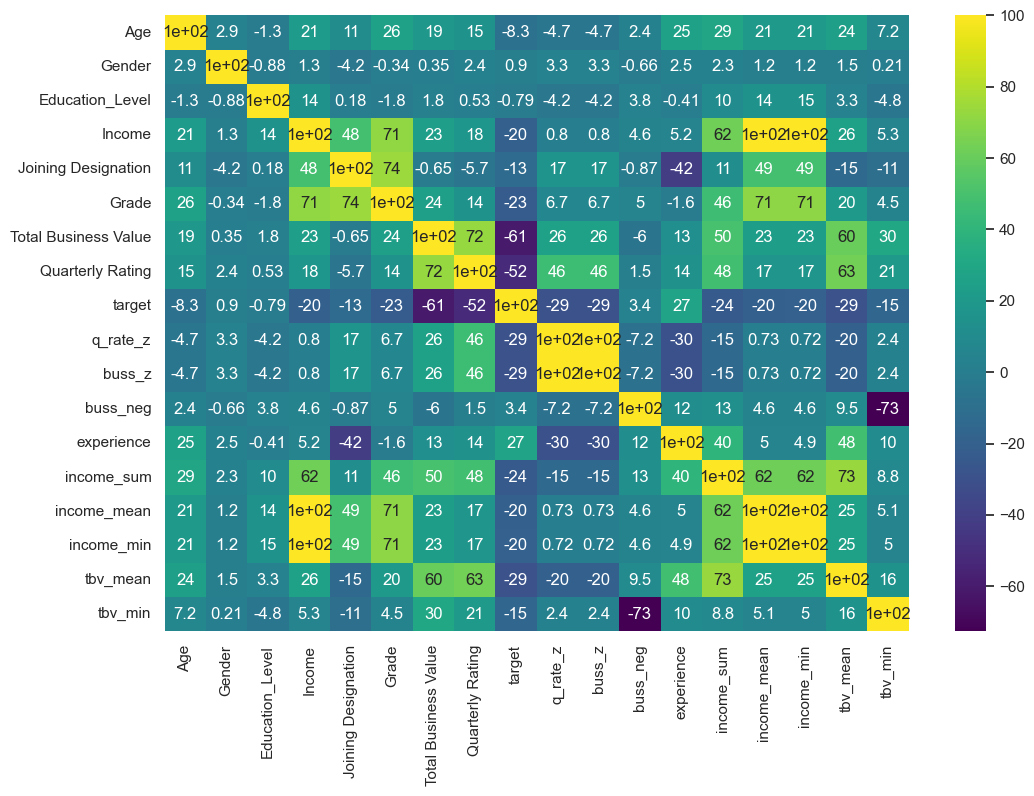

In [138]:
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, cmap='viridis')
plt.show()

In [139]:
df_.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,q_rate_z,buss_z,buss_neg,experience,income_sum,income_mean,income_min,tbv_mean,tbv_min
0,28.0,0.0,C23,2,57387,1,1,0,2,1,0.000000,0.000000,1,24,172161,57387.0,57387,571860.0,-665480
1,31.0,0.0,C7,2,67016,2,2,0,1,0,0.000000,0.000000,0,1,134032,67016.0,67016,0.0,0
2,43.0,0.0,C13,2,65603,2,2,0,1,1,0.000000,0.000000,0,12,328015,65603.0,65603,70000.0,0
3,29.0,0.0,C9,0,46368,1,1,0,1,1,0.000000,0.000000,0,23,139104,46368.0,46368,40120.0,0
4,31.0,1.0,C11,1,78728,3,3,0,2,0,0.816497,0.816497,0,5,393640,78728.0,78728,253000.0,0


In [141]:
df_.City.nunique()

29

In [142]:
X = df_.drop(columns=['target'])
y = df_['target']

In [143]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, stratify=y, random_state=42)

In [144]:
import category_encoders as ce

ce_target = ce.TargetEncoder(cols = ['City'])
X_train = ce_target.fit_transform(X_train, y_train)
X_test = ce_target.transform(X_test)

In [147]:
tree_clf = DecisionTreeClassifier()

In [148]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [149]:
tree_clf.score(X_train, y_train)  #train accuracy

1.0

In [150]:
tree_clf.score(X_test, y_test) # test accuracy

0.8942953020134228

In [157]:
kfold = KFold(n_splits = 5)

In [158]:
cv_acc_results = cross_validate(tree_clf, X_train, y_train, scoring='accuracy',
                                cv = kfold, return_train_score = True  )

In [161]:
cv_acc_results['train_score'].mean()

1.0

In [162]:
cv_acc_results['test_score'].mean()

0.8879551820728292

In [173]:
print(classification_report(y_test, tree_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       191
           1       0.92      0.92      0.92       405

    accuracy                           0.89       596
   macro avg       0.88      0.88      0.88       596
weighted avg       0.89      0.89      0.89       596



In [163]:
from sklearn.tree import plot_tree

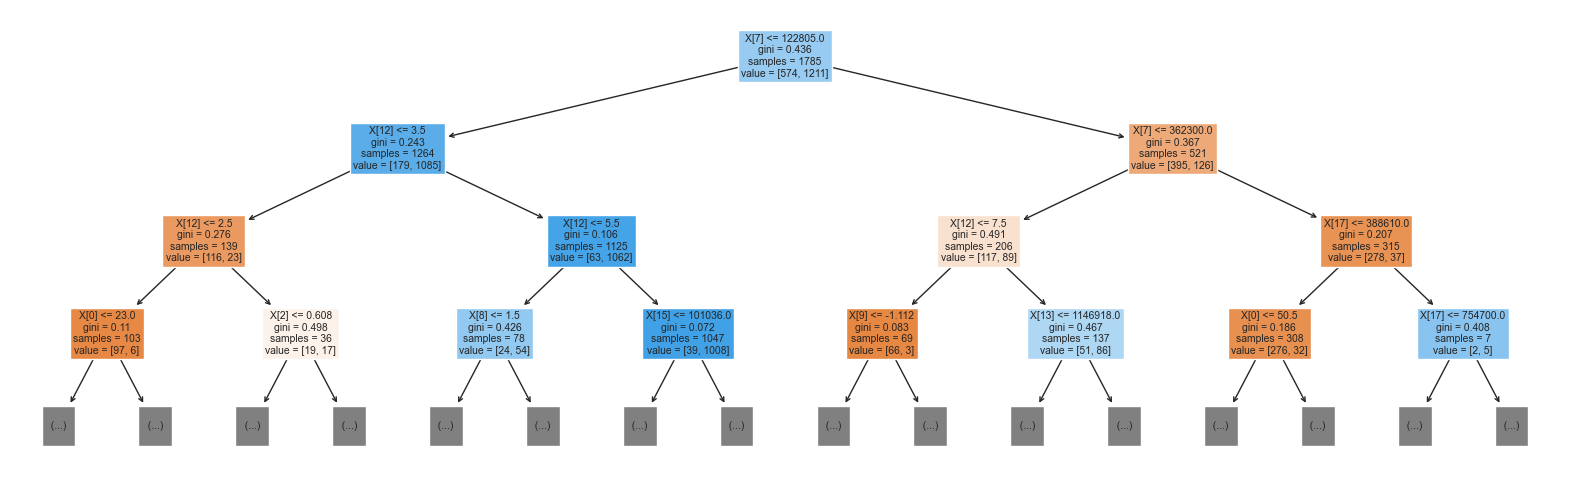

In [165]:
plt.figure(figsize = (20, 6))
plot_tree(tree_clf, max_depth = 3, filled = True)
plt.show()

In [177]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100)

kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(rfc, X_train, y_train, cv = kfold, 
                                scoring = 'f1', 
                                return_train_score = True)

print(f"K-Fold Accuracy Mean: Train: {cv_acc_results['train_score'].mean().round(3)*100} Validation: {cv_acc_results['test_score'].mean().round(3)*100}")


K-Fold Accuracy Mean: Train: 100.0 Validation: 93.60000000000001


In [169]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [172]:
accuracy_score(y_test, rfc.predict(X_test))

0.9261744966442953

In [174]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       191
           1       0.94      0.95      0.95       405

    accuracy                           0.93       596
   macro avg       0.92      0.91      0.91       596
weighted avg       0.93      0.93      0.93       596



In [175]:
from tqdm import tqdm

In [178]:
x_values = [] 

y_values_valid_scores = []

for k in tqdm(range(25, 310, 25)):
    
    print(f"Traing with {k} Decision Trees")
    rfc = RandomForestClassifier(random_state=7, n_estimators=k,class_weight='balanced') ## i am letting each DT overfit

    kfold = KFold(n_splits=10)
    cv_acc_results = cross_validate(rfc, X_train, y_train, cv = kfold, 
                                    scoring = 'f1', 
                                    return_train_score = True)

    y_values_valid_scores.append(cv_acc_results['test_score'].mean().round(3)*100)
    x_values.append(k)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Traing with 25 Decision Trees


  8%|██████▉                                                                            | 1/12 [00:00<00:06,  1.75it/s]

Traing with 50 Decision Trees


 17%|█████████████▊                                                                     | 2/12 [00:01<00:08,  1.20it/s]

Traing with 75 Decision Trees


 25%|████████████████████▊                                                              | 3/12 [00:03<00:10,  1.15s/it]

Traing with 100 Decision Trees


 33%|███████████████████████████▋                                                       | 4/12 [00:05<00:12,  1.53s/it]

Traing with 125 Decision Trees


 42%|██████████████████████████████████▌                                                | 5/12 [00:07<00:13,  1.92s/it]

Traing with 150 Decision Trees


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:10<00:13,  2.30s/it]

Traing with 175 Decision Trees


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:14<00:13,  2.62s/it]

Traing with 200 Decision Trees


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:18<00:12,  3.01s/it]

Traing with 225 Decision Trees


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:22<00:10,  3.45s/it]

Traing with 250 Decision Trees


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:27<00:07,  3.85s/it]

Traing with 275 Decision Trees


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:32<00:04,  4.25s/it]

Traing with 300 Decision Trees


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:38<00:00,  3.19s/it]


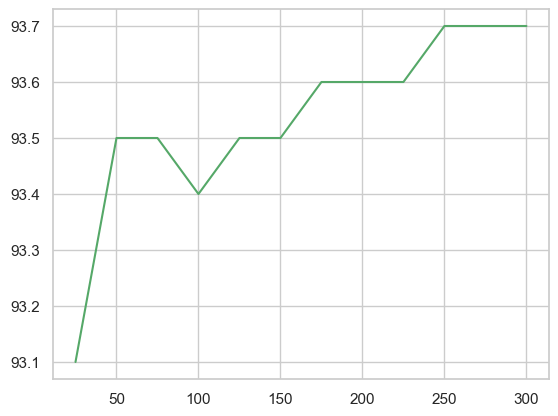

In [179]:
plt.plot(x_values, y_values_valid_scores, color = "g")

plt.show()

In [182]:
rfc = RandomForestClassifier(random_state=42, n_estimators=175,class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=175,
                       random_state=42)

In [183]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       191
           1       0.93      0.96      0.95       405

    accuracy                           0.92       596
   macro avg       0.92      0.91      0.91       596
weighted avg       0.92      0.92      0.92       596



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

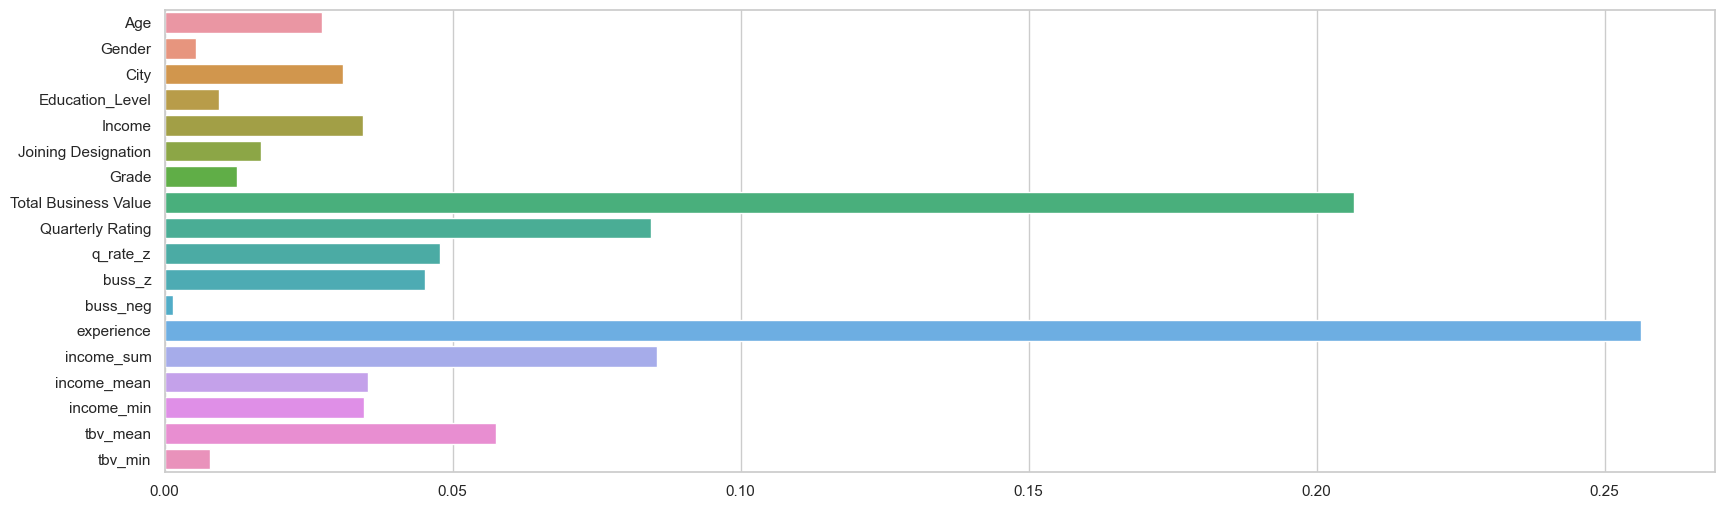

In [188]:
plt.figure(figsize = (20, 6))
sns.barplot(rfc.feature_importances_,rfc.feature_names_in_ )

In [ ]:
Experience, Total Business Value, Income, Quarterly Rating, 

In [191]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [194]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_res, y_train_res)

GradientBoostingClassifier()

In [195]:
gbc.score(X_test,y_test)

0.9328859060402684

In [198]:
print(classification_report(y_test,gbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       191
           1       0.95      0.95      0.95       405

    accuracy                           0.93       596
   macro avg       0.92      0.92      0.92       596
weighted avg       0.93      0.93      0.93       596



### Final Result Evaluation : 
####     Decision Tree results :
            Precision : 0.92 , Recall : 0.92
####     Random Forest results :
            Precision : 0.93 , Recall : 0.96


####    Gredient Boosting results : 
            Precision : 0.95 , Recall : 0.95

###### We achieved best results with Gredient Boosting with 0.95 Precision and recall both, which is excellent in terms of the accuracy, we have build a very good model here.

#### Insights and Recommendations
So we see that there are 57% male employees and 43% female employees. \
The percentages of employees with different education levels are almost same for level 1 & 2. \
97.3% of the employees who did not get a raise. \
Almost 43% of the employees joined at lowest designation (1). 34% joined at level 2, 20% at level 3 and below 2% joined at higher levels. \
Majority (35%) of the employees currently are at designation level 2, followed by designation level 1 (31%) and 3 (26%). Less than 5% of the employees are currently in higher designations. \
Only 54.6% of the employees received a promotion, while 45.4% did not. However, only 2.6% received a raise in income. \
The majority of the employees seem to be associated with city C20. \
Scatter plot of Income shows that Income increases with increase in age but after 45-50, we see a subtle decline. \
Scatter plot of Total Business Value shows an increase with increase in Age yet we notice a decline after 45. \
Income decreses with increase in Destination as about 4% of the employees hold higher designations. \
The median of the Income for employees having higher Grades is greater. \
Distribution of Income for employes at different Education level is about a change of 3-5% with level 0. \
Joining Designation Increases with increase in Grade. \
About 55% of the reportings of the employees has got Quarlerly Rating 1. \
Number of reportings increases with increase in Income as well as Total Business Value. \
Recall increased after treatment of data imbalance and is performing bettee in Gradient Boosting. \
Precision dropped after treatment of data imbalance and is performing better in Random Forest. \
F1_score incresed after the treatment of imabalanced data and in Gradient Boosting. \
Experience, Total Business Value, Income, Quarterly Rating are contributiong heavily for the classification